# Dating Prediction

## Loading Data

   age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on college/university   
4  graduated from college/university   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   
2  i'm not ashamed of much, but writing public te...   
3          i work in a library and go to school. . .   
4  hey how's it going? currently vague on the pro...   

                         

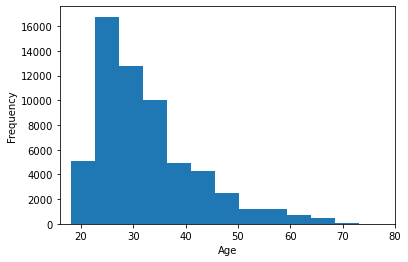

In [119]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

df = pd.read_csv("profiles.csv")

print(df.head())
print(df.columns)

print(df.isna().any())

plt.hist(df.age, bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xlim(16, 80)
plt.show()

# Drop missing value columns
df = df.dropna(subset=["education","sign","drinks","smokes","drugs"])

Mapping value to int

In [120]:
# Mapping str values to numerical
df["drinks_code"] = df.drinks.map({
    "not at all" : 0,
    "rarely" : 1,
    "socially" : 2,
    "often" : 3,
    "very often" : 4,
    "desperately" : 5
})

df["smokes_code"] = df.smokes.map({
    "no":0,
    "sometimes":1,
    "when drinking":2,
    "yes":3,
    "trying to quit":4
})

df["drugs_code"] = df.drugs.map({
    "never":0,
    "sometimes":1,
    "often":2
})

Mapping essays columns

In [121]:
# Retrieve the essays cols
essays_cols = ["essay0","essay1","essay2","essay3","essay4","essay5",
               "essay6","essay7","essay8","essay9"]

# Removing the NaNs
all_essays = df[essays_cols].replace(np.nan,'',regex=True)

# Combining the essays
all_essays = all_essays[essays_cols].apply(lambda x:' '.join(x),axis=1)

# Total length of the ssays
df["essay_len"] = all_essays.apply(lambda x : len(x))

# Average length for essays
df["avg_word_length"] = df["essay_len"]/len(essays_cols)

# Frequency of the words 'I' or 'me"
df["common_words"] = all_essays.str.count(r'\b(I|me)\b', flags=re.IGNORECASE)

### Normalize Data

In [122]:
feature_data = df[["smokes_code","drinks_code","drugs_code",
                   "essay_len","avg_word_length"]]

x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

### Predict Zodiac Signs

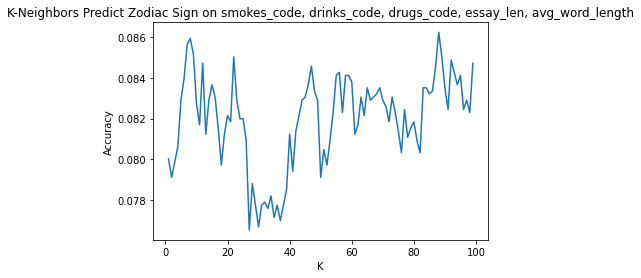

In [123]:
# Replace N/A values with blank
df["sign"] = df["sign"].replace(np.nan,'',regex=True)

# Only take the first word, which is the zodiac sign only
df["sign"] = (df["sign"].apply(lambda x: x.split(" ")[0]))

X_train, X_test, y_train, y_test = train_test_split(feature_data,df["sign"],test_size=0.2,random_state=100)

accuracies = []

for k in range(1,100):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train,y_train)
    accuracies.append(classifier.score(X_test,y_test))

fig, ax = plt.subplots()

ax.plot(range(1,100),accuracies)
ax.set_xlabel("K")
ax.set_ylabel("Accuracy")
ax.set_title("K-Neighbors Predict Zodiac Sign on smokes_code, drinks_code, drugs_code, essay_len, avg_word_length")

plt.savefig("zodiac_sign_prediction.jpg")

## Classification Techniques

### Predict Sex with education level and income using K Nearest Neighbors

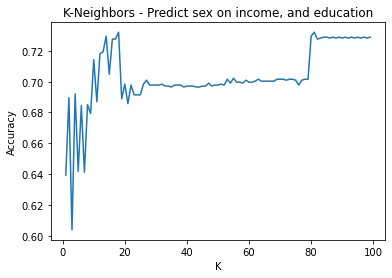

In [124]:
# Male = 0 , Female = 1
df["sex_code"] = df.sex.map({
    "m": 0,
    "f": 1
})

# Remove rows with missing income
df = df[df["income"] != -1]

# Remove education null field
df = df.dropna(subset=["education"])

# Change the education category string to int type
label_encoder = preprocessing.LabelEncoder()
df["education_code"] = label_encoder.fit_transform(df["education"])

X = df[["income", "education_code"]]
y = df["sex_code"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

accuracies = []

for k in range(1, 100):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    accuracies.append(classifier.score(X_test, y_test))

fig, ax = plt.subplots()

ax.plot(range(1,100),accuracies)
ax.set_xlabel("K")
ax.set_ylabel("Accuracy")
ax.set_title("K-Neighbors - Predict sex on income, and education")

plt.savefig("sex_income-education.jpg")


### Predict Sex with education level and income using Decision Trees


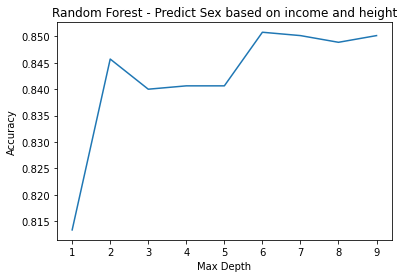

In [125]:
from sklearn.ensemble import RandomForestClassifier

features = df[["income", "height"]]
y = df["sex_code"]

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)

accuracies = []

for depth in range(1,10):
    classifier = RandomForestClassifier(max_depth=depth)
    classifier.fit(X_train,y_train)
    accuracies.append(classifier.score(X_test,y_test))

fig, ax = plt.subplots()

ax.plot(range(1,10),accuracies)
ax.set_xlabel("Max Depth")
ax.set_ylabel("Accuracy")
ax.set_title("Random Forest - Predict Sex based on income and height")

plt.savefig("sex_income-height.jpg")

### Predict education level with essay text word counts

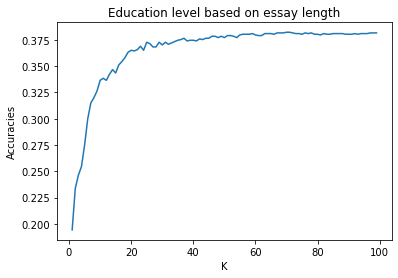

In [126]:
features = df[["essay_len"]]
y = df["education_code"]

X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.2)

accuracies = []

for k in range(1,100):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    accuracies.append(classifier.score(X_test,y_test))

fig, ax = plt.subplots()

ax.plot(range(1,100),accuracies)
ax.set_xlabel("K")
ax.set_ylabel("Accuracies")
ax.set_title("Education level based on essay length")

plt.savefig("education_essaylen.jpg")

## Regression Techniques

### Predict income with length of essays and average word length using MLR

In [127]:
features = df[["essay_len","avg_word_length"]]

X_train, X_test, y_train, y_test = train_test_split(features,df["income"],test_size=0.2)
classifier = LinearRegression()
classifier.fit(X_train,y_train)

print("Test score: ", classifier.score(X_train,y_train))


Test score:  9.325618778766032e-05


### Predict income with length of essays and average word length using KNN

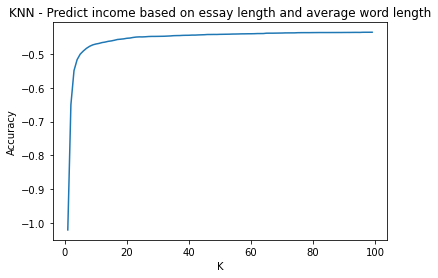

In [128]:
features = df[["essay_len","avg_word_length"]]

X_train, X_test, y_train, y_test = train_test_split(features,df["income"],test_size=0.2)

accuracies = []

for k in range(1,100):
    classifier = KNeighborsRegressor(n_neighbors=k,weights="distance")
    classifier.fit(X_train,y_train)
    accuracies.append(classifier.score(X_test,y_test))

fig, ax = plt.subplots()

ax.plot(range(1,100),accuracies)
ax.set_xlabel("K")
ax.set_ylabel("Accuracy")
ax.set_title("KNN - Predict income based on essay length and average word length")

plt.savefig("income_essay-length-avg-word-length.jpg")

### Predict Age with the fequency of "I" or "Me" in essays using MLR

In [129]:
features = df[["common_words"]]
y = df["age"]

X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.2,random_state=5)

classifier = LinearRegression()
classifier.fit(X_train,y_train)
print(classifier.score(X_test,y_test))

-0.0006745776603436227


### Predict Age with the fequency of "I" or "Me" in essays using KNN

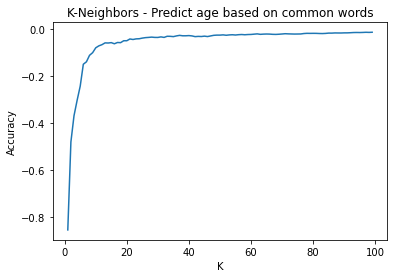

In [130]:
features = df[["common_words"]]
y = df["age"]

X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.2,random_state=5)

accuracies = []

for k in range(1,100):
    classifier = KNeighborsRegressor(n_neighbors=k,weights="distance")
    classifier.fit(X_train,y_train)
    accuracies.append(classifier.score(X_test,y_test))

fig, ax = plt.subplots()

ax.plot(range(1,100),accuracies)
ax.set_xlabel("K")
ax.set_ylabel("Accuracy")
ax.set_title("K-Neighbors - Predict age based on common words")

plt.savefig("age_common-words.jpg")